In [ ]:
# ============================================
# 0) Imports & setup
# ============================================
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")
pd.set_option("display.max_columns", None)

In [45]:
# ============================================
# 1) Load preprocessed artifacts
# - Clean (encoded) dataset
# - Clean + scaled dataset
# - Encoders & scaler
# ============================================

df = pd.read_csv("../data/german_credit_data_clean.csv")
df_scaled = pd.read_csv("../data/german_credit_data_clean_scaled.csv")

encoders = joblib.load("../models/label_encoders.pkl")
scaler    = joblib.load("../models/standard_scaler.pkl")

print(df.shape, df_scaled.shape)  # Both of them should be (1000, 9)
df.head(2)

(1000, 9) (1000, 9)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,4,0,1169,6,5
1,22,0,2,1,0,1,5951,48,5


In [46]:
# ============================================
# 2) First clustering baseline (KMeans)
# We'll start simple with 3 clusters; we'll tune later with elbow/silhouette.
# ============================================
X = df_scaled[["Age", "Duration", "Credit amount", "Sex", "Job", "Housing",
               "Saving accounts", "Checking account", "Purpose"]].values

kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X)

df_clusters = df.copy()
df_clusters["cluster"] = labels

# quick view of cluster sizes
df_clusters["cluster"].value_counts().sort_index()


cluster
0    147
1    408
2    445
Name: count, dtype: int64

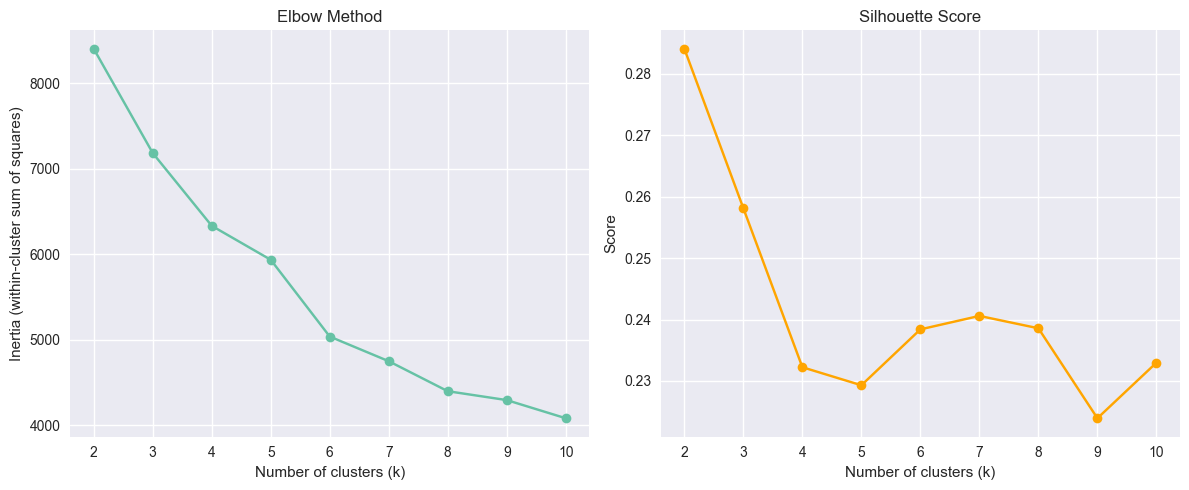

In [47]:
# ============================================
# 3) Optimize cluster count: Elbow & Silhouette
# ============================================

X = df_scaled[["Age", "Duration", "Credit amount", "Sex", "Job", "Housing",
               "Saving accounts", "Checking account", "Purpose"]].values

inertia = []        # # total error for each k
silhouette_scores = []  # silhouette score for each k

K = range(2, 11)  # test cluster numbers from 2 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X)
    
    inertia.append(kmeans.inertia_)  # total error
    silhouette_scores.append(silhouette_score(X, labels))  # quality

# --- Let's plot the graphs ---
plt.figure(figsize=(12,5))

# Elbow
plt.subplot(1,2,1)
plt.plot(K, inertia, marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster sum of squares)")

# Silhouette
plt.subplot(1,2,2)
plt.plot(K, silhouette_scores, marker="o", color="orange")
plt.title("Silhouette Score")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score")

plt.tight_layout()
plt.show()


## Cluster Number Optimization (Elbow & Silhouette)

Initially, I chose 3 clusters for KMeans, but I wanted to check whether this choice was correct. Therefore, I applied the **Elbow Method** and **Silhouette Score**.  

- In the Elbow chart, I observed a clear bend around **k=3 or k=4**.  
- In the Silhouette score, the highest value appeared at **k=2**, but this would have resulted in overly simplistic clusters. A more balanced and meaningful choice was clearly **k=3**.  

After this analysis, I confirmed that my initial choice of **3 clusters was indeed reasonable**.
